In [1]:
import numpy as np
import torch
import os
import matplotlib.pyplot as plt
import math
from torch import nn
from torch.utils import data
from d2l import torch as d2l
import pandas as pd
from sklearn.model_selection import train_test_split 
from IPython import display
%matplotlib inline
from torch.nn import functional as F



In [2]:
## 初代数读取方案
# import os
# print(os.path.abspath('.'))


# #读取训练数据集 和  测试数据集
# all_feature = pd.read_csv("../data/train_set.csv")
# all_test = pd.read_csv("../data/test_set.csv")
# # 先是pands类型的数据 进行数据切片 分为 数据和label  
# # feature 是 float32  label 是长整型
# feature = all_feature.iloc[:,0:-1].astype(np.float32)
# label = all_feature.iloc[:,-1].astype(np.compat.long)

# test_feature = all_test.iloc[:,0:-1].astype(np.float32)
# test_label = all_test.iloc[:,-1].astype(np.compat.long)

# # 把 俩个变量 feature 和 label 做成 list 
# class GetLoader(torch.utils.data.Dataset):
# 	# 初始化函数，得到数据
#     def __init__(self, data_root, data_label):
#         self.data = data_root
#         self.label = data_label
#     # index是根据batchsize划分数据后得到的索引，最后将data和对应的labels进行一起返回
#     def __getitem__(self, index):
#         data = self.data[index]
#         labels = self.label[index]
#         return data, labels
#     # 该函数返回数据大小长度，目的是DataLoader方便划分，如果不知道大小，DataLoader会一脸懵逼
#     def __len__(self):
#         return len(self.data)

# # 再把np array 类型的数据转化为tensor 类型
# feature = torch.tensor(feature.values)
# label = torch.tensor(label.values).type(torch.long)

# test_feature = torch.tensor(test_feature.values)
# test_label = torch.tensor(test_label.values).type(torch.long)

# #生成训练集和测试集
# dataset = GetLoader(feature,label)

# test_dataset = GetLoader(test_feature,test_label)

# test_feature

# next(iter(test_dataset))

## 后续学习 输入的宽度应该不止70个数据了 （可以修改的）

In [3]:
##找到当前存放数据的路劲 （批量读取数据）##
os.chdir(r'C:\\Users\\86136\\PycharmProjects\\pythonProject\\AI -learn from zero\\tem_dataset')
##  要切换到的新路径  可以%pwd 查看当前路径
file_chdir = os.getcwd() ##  获取当前路径
file_name_list=[]
file_list=[] 
for root,dirs,files in os.walk(file_chdir):  ## file_chdir :代表需要遍历的根文件夹  root :表示正在遍历的文件夹的名字（根/子）
                                            ## dirs :记录正在遍历的文件夹下的子文件夹集合  files:记录正在遍历的文件夹中的文件集合(list形式)
    for file in files:
        if os.path.splitext(file)[-1] =='.csv': ## os.path.splitext()  分离文件名与扩展名；默认返回(fname,fextension)元组 切片后-1 表示后缀
            file_name_list.append(file)
            print(file_name_list)
            file_list.append(pd.read_csv(file,index_col=0))

feature = np.empty(shape=(0,3)) ## 创建空的np array 必须要有shape 参数
label = np.empty(shape=(0,3))
## 将label 和 feature 分开
for i in range(len(file_list)):
    label = np.append(label,np.array(file_list[i].iloc[:,-1]))
    feature = np.append(feature,np.array(file_list[i].iloc[:,0:-1]))

## 将数据分为多组的 输入和label  （这里label 用于做one hot 只能是一维的输入  因此不适用 reshape）
feature= feature.reshape(-1,1,70)
label = label/10

## 这里的splite 已经自带 shuffle 
features,test_feature,labels,test_label =  train_test_split(feature, label, test_size=0.2) ## 特定的库中 适用的分离 训练集和测试集的方法

## 将数据类型转化为tensor
features = torch.from_numpy(features).float().reshape(-1,70,1)  ## 这里重置了数据 为三维的tensor
labels = torch.from_numpy(labels).long()
test_feature =torch.from_numpy(test_feature).float().reshape(-1,70,1)
test_label = torch.from_numpy(test_label).long()

['100ppms1_dset.csv']
['100ppms1_dset.csv', '10ppms1_dset.csv']
['100ppms1_dset.csv', '10ppms1_dset.csv', '20ppms1_dset.csv']
['100ppms1_dset.csv', '10ppms1_dset.csv', '20ppms1_dset.csv', '30ppms1_dset.csv']
['100ppms1_dset.csv', '10ppms1_dset.csv', '20ppms1_dset.csv', '30ppms1_dset.csv', '40ppms1_dset.csv']
['100ppms1_dset.csv', '10ppms1_dset.csv', '20ppms1_dset.csv', '30ppms1_dset.csv', '40ppms1_dset.csv', '50ppms1_dset.csv']
['100ppms1_dset.csv', '10ppms1_dset.csv', '20ppms1_dset.csv', '30ppms1_dset.csv', '40ppms1_dset.csv', '50ppms1_dset.csv', '60ppms1_dset.csv']
['100ppms1_dset.csv', '10ppms1_dset.csv', '20ppms1_dset.csv', '30ppms1_dset.csv', '40ppms1_dset.csv', '50ppms1_dset.csv', '60ppms1_dset.csv', '70ppms1_dset.csv']
['100ppms1_dset.csv', '10ppms1_dset.csv', '20ppms1_dset.csv', '30ppms1_dset.csv', '40ppms1_dset.csv', '50ppms1_dset.csv', '60ppms1_dset.csv', '70ppms1_dset.csv', '80ppms1_dset.csv']
['100ppms1_dset.csv', '10ppms1_dset.csv', '20ppms1_dset.csv', '30ppms1_dset.csv', 

In [4]:
## 使用dataloder  和 tensordataset ： 把 多个tensor 变成 多元组 因此每个tensor的长度必须一致
def load_array(data_arrays,batch_size,is_train = True):
    dataset =data.TensorDataset(*data_arrays)   ## TensorDataset的作用是将多个的tensor 变成一个多元组  其中*data_array的第一维度长度必须相等
    return data.DataLoader(dataset,batch_size,shuffle =False)
def load_test(data_arrays,batch_size,is_test = False):
    dataset =data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset,batch_size,shuffle =False)
batch_size =10  # 超参数
seed=10 ## 随机种子
torch.manual_seed(seed)
data_iter = load_array((features,labels),batch_size) # 训练集
test_iter = load_test((test_feature,test_label),batch_size)  # 测试集

next(iter(test_iter))

[tensor([[[0.5197],
          [0.5203],
          [0.5210],
          [0.5200],
          [0.5187],
          [0.5207],
          [0.5191],
          [0.5200],
          [0.5197],
          [0.5194],
          [0.5197],
          [0.5216],
          [0.5197],
          [0.5203],
          [0.5191],
          [0.5197],
          [0.5197],
          [0.5203],
          [0.5187],
          [0.5191],
          [0.5203],
          [3.0871],
          [3.6313],
          [3.7921],
          [3.8347],
          [3.8421],
          [3.8369],
          [3.8437],
          [3.8334],
          [3.8269],
          [3.8269],
          [3.8166],
          [3.8089],
          [3.8105],
          [3.8018],
          [3.7915],
          [3.7828],
          [3.7876],
          [3.7783],
          [3.7718],
          [3.7738],
          [3.7670],
          [3.7576],
          [3.7499],
          [3.7564],
          [3.7480],
          [3.7422],
          [3.7451],
          [3.7370],
          [3.7312],


In [5]:
# 初始化权重（W）和偏置（b）
device=d2l.try_gpu()
num_inputs = 70
num_hiddens = 10
num_outputs = 10
H = torch.zeros((batch_size, num_hiddens),requires_grad=True,device=device)
W_xh =torch.normal(0, 0.01,size=(batch_size,num_hiddens),requires_grad=True,device=device)
W_hh =torch.normal(0, 0.01,size=(num_hiddens,num_hiddens),requires_grad=True,device=device)
b_h =torch.zeros(num_hiddens,requires_grad=True,device=device)
W_hq = torch.normal(0, 0.01,size=(num_hiddens,num_outputs),requires_grad=True,device=device)
b_q = torch.zeros((batch_size,num_outputs), requires_grad=True,device=device)
params = [W_xh,W_hh,b_h,W_hq,b_q]
all_params =[W_xh,W_hh,b_h,W_hq,b_q,H]
# W = torch.normal(0, 0.01, size=(num_inputs, num_outputs), requires_grad=True)  这是softmax的初始化
# b = torch.zeros(num_outputs, requires_grad=True)

In [6]:
# 定义softmax函数 
# softmax的含义将 net 输出的矩阵的每一行 变化成 softmax的模式 
#意思是需要将一行的元素做e指数求和 再用每个元素的e指数来除以它
def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(1, keepdim=True)
    return X_exp / partition  # 这里应用了广播机制

In [7]:
# 这里的net之定义了一个矩阵的乘法
def net(data_feature,W_xh,W_hh,b_h,W_hq,b_q,H):
    data_feature = torch.transpose(data_feature,0,1)
    params = [W_xh,W_hh,b_h,W_hq,b_q]
    for X in data_feature:
        #print(f'X={X.shape}')
        X =X.reshape(1,min(W_xh.shape[0],X.shape[0]))
        X =X.to(device)
        H = torch.tanh(torch.mm(X, W_xh)+ torch.mm(H, W_hh)+ b_h)
        for p in params:
            if p.grad is not None:
#                 print(torch.sqrt(torch.sum(p.grad ** 2)))
                norm= torch.sqrt(torch.sum(p.grad ** 2))
                if norm > 1:
                    for param in params:
                        param.grad[:] *= 1 / norm  ## inplace 操作  直接改写
    Y = torch.mm(H.reshape(10,10), W_hq) + b_q 
    Y =Y.to(device)
    return softmax(Y)
#    return softmax(torch.matmul(X.reshape((-1, W.shape[0])), W) + b) ## softmax的返回值

In [8]:
# 这里的是调试的需求
# y_hat=net(feature)
# y_hat = y_hat.argmax(axis=1)
# y_hat
# cmp = y_hat.type(label.dtype) ==label
# cmp

y_ha = torch.tensor([[0.1,0.3,0.6],[0.2,0.3,0.5]])
y = torch.tensor([0,2])

y_ha[range(len(y_ha)),y]

In [9]:
# 这里的cross_entrop 是作为损失函数
def cross_entropy(y_hat, y):
    return - torch.log(y_hat[range(len(y_hat)), y])


In [10]:
#cross_entropy(y_hat,label)

In [11]:
#比较真实的输出 和 label 的比较结果
def accuracy(y_hat, y,device):  #@save
    """计算预测正确的数量"""
    y_hat = y_hat.to(device)
    y = y.to(device)
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

In [12]:
#评估准确度 
# 测试模型的时候一般定义为eval（）模式  因为这个时候只进行前向的求导 不更新权重
#训练完train_datasets之后，model要来测试样本了。在model(test_datasets)之前，
#需要加上model.eval(). 否则的话，有输入数据，即使不训练，它也会改变权值。
#这是model中含有batch normalization层所带来的的性质。
def evaluate_accuracy(net, data_iter):  #@save
    """计算在指定数据集上模型的精度"""
    if isinstance(net, torch.nn.Module):
        net.eval()  # 将模型设置为评估模式  
    metric = d2l.Accumulator(2)  # 正确预测数、预测总数
    with torch.no_grad():
        for X, y in data_iter:
            if X.shape[0]<batch_size:  ## =剩余数据不足batch_size 就舍弃
                continue
            else:
                #print(f'xshape={X.shape}')
                y=y.T.reshape(-1)
                metric.add(accuracy(net(X,W_xh,W_hh,b_h,W_hq,b_q,H), y,device), y.numel())
    return metric[0] / metric[1]

In [13]:
# class Accumulator:  #@save
#     """在n个变量上累加"""
#     def __init__(self, n):
#         self.data = [0.0] * n

#     def add(self, *args):
#         self.data = [a + float(b) for a, b in zip(self.data, args)]

#     def reset(self):
#         self.data = [0.0] * len(self.data)

#     def __getitem__(self, idx):
#         return self.data[idx]

In [14]:
evaluate_accuracy(net, data_iter)

0.10888888888888888

In [15]:
# update 雅传如 W，b lr 哈有batch_size
def updater(batch_size):
    return d2l.sgd(params,lr,batch_size)  ## 这里把Ｈ　和　不含有Ｈ　的都试过　差别不大
#    return d2l.sgd([W, b], lr, batch_size)

In [16]:
def train_epoch_ch3(net, train_iter, loss, updater,device):  #@save
    """训练模型一个迭代周期（定义见第3章）"""
    # 将模型设置为训练模式
    if isinstance(net, torch.nn.Module):
        net.train()
    # 训练损失总和、训练准确度总和、样本数
    metric = d2l.Accumulator(3)
    for X, y in train_iter:
        # 计算梯度并更新参数
        if X.shape[0]<batch_size:  ## =剩余数据不足batch_size 就舍弃
            continue
        else:
            #print(f'x1={X.shape}')
            y=y.T.reshape(-1)
            X, y = X.to(device), y.to(device)
            y_hat = net(X,W_xh,W_hh,b_h,W_hq,b_q,H) ## 补充参数
            l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            # 使用PyTorch内置的优化器和损失函数
            updater.zero_grad()
            l.mean().backward()
#             print(f'l.mean{l.mean()}')
            updater.step()
        else:
            # 使用定制的优化器和损失函数
            l.sum().backward()
#             print(f'l.sum{l.sum()}')
            updater(X.shape[0])
        metric.add(float(l.sum()), accuracy(y_hat, y,device), y.numel())
    # 返回训练损失和训练精度
    return metric[0] / metric[2], metric[1] / metric[2]

In [17]:
lr =0.01
train_epoch_ch3(net,data_iter,cross_entropy,updater,device)

RuntimeError: transform: failed to synchronize: cudaErrorAssert: device-side assert triggered

In [ ]:
# class Animator:  #@save
#     """在动画中绘制数据"""
#     def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
#                  ylim=None, xscale='linear', yscale='linear',
#                  fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
#                  figsize=(3.5, 2.5)):
#         # 增量地绘制多条线
#         if legend is None:
#             legend = []
#         d2l.use_svg_display()
#         self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
#         if nrows * ncols == 1:
#             self.axes = [self.axes, ]
#         # 使用lambda函数捕获参数
#         self.config_axes = lambda: d2l.set_axes(
#             self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
#         self.X, self.Y, self.fmts = None, None, fmts

#     def add(self, x, y):
#         # 向图表中添加多个数据点
#         if not hasattr(y, "__len__"):
#             y = [y]
#         n = len(y)
#         if not hasattr(x, "__len__"):
#             x = [x] * n
#         if not self.X:
#             self.X = [[] for _ in range(n)]
#         if not self.Y:
#             self.Y = [[] for _ in range(n)]
#         for i, (a, b) in enumerate(zip(x, y)):
#             if a is not None and b is not None:
#                 self.X[i].append(a)
#                 self.Y[i].append(b)
#         self.axes[0].cla()
#         for x, y, fmt in zip(self.X, self.Y, self.fmts):
#             self.axes[0].plot(x, y, fmt)
#         self.config_axes()
#         display.display(self.fig)
#         display.clear_output(wait=True)

In [18]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater,device):  #@save
    """训练模型（定义见第3章）"""
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.1, 1],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater,device)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc

RuntimeError: CUDA error: device-side assert triggered

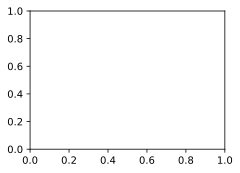

In [19]:
lr =0.01
# batch_size = 10
num_epochs = 100
train_ch3(net, data_iter, test_iter, cross_entropy, num_epochs, updater,device)

In [ ]:
W

In [ ]:
print(net)